# EDA and Hypothesis Testing for an Event Ticketing Service

- **Author**: Ekaterina Kemenova
- **Date**: 29.01.2026

## 0.1 Project goals and objectives

**Goal:**  
To perform an exploratory and statistical analysis of data from Yandex Afisha, an event discovery and ticketing service, in order to identify seasonal changes in user behavior and event demand in autumn 2024.

**Context:**  
The product team requires data-driven insights into seasonal changes in user demand to support planning for sales and promotional campaigns. 

**Key objectives:**
- Load and explore the datasets;
- Perform data preprocessing (handle errors, incorrect data types, missing values, duplicates, outliers);
- Engineer additional features required for the analysis;
- Conduct exploratory data analysis and study:
  - Seasonal changes in order distribution across segments;
  - User activity patterns during the autumn period;
  - The most popular regions and ticketing partners;
- Perform statistical analysis and test product hypotheses:
  - Average number of orders per user on mobile vs. desktop;
  - Average time between orders on mobile vs. desktop;
- Summarize findings and provide data-driven recommendations.

## 0.2 Data description

The project is based on Yandex Afisha ticket booking data covering **June 1 to October 30, 2024**.

The **`final_tickets_orders_df.csv`** dataset includes order-level information:

- `order_id` — unique order identifier;
- `user_id` — unique user identifier;
- `created_dt_msk` — order date (Moscow time);
- `created_ts_msk` — order timestamp (Moscow time);
- `event_id` — event identifier;
- `cinema_circuit` — cinema chain (if not applicable, the value is `нет`);
- `age_limit` — event age rating;
- `currency_code` — transaction currency (`rub`, `kzt`);
- `device_type_canonical` — device type (`mobile`, `desktop`);
- `revenue` — order revenue;
- `service_name` — ticketing partner / operator;
- `tickets_count` — number of tickets per order;
- `total` — total order amount;
- `days_since_prev` — days since the user’s previous purchase (missing for first-time purchases).

The **`final_tickets_events_df.csv`** dataset contains event-level information, including the event’s city/region and venue details:

- `event_id` — unique event identifier;
- `event_name` — event name;
- `event_type_description` — event type description;
- `event_type_main` — main event category (concert, theater, etc.);
- `organizers` — event organizers;
- `region_name` — event region;
- `city_name` — event city;
- `venue_id` — unique venue identifier;
- `venue_name` — venue name;
- `venue_address` — venue address.

A supplementary dataset, **`final_tickets_tenge_df.csv`**, provides the KZT-to-RUB exchange rate for 2024:

- `nominal` — currency nominal (100 KZT);
- `data` — date;
- `curs` — exchange rate (KZT to RUB);
- `cdx` — currency code (`kzt`).

## 0.3 Project structure

1. [Data loading and overview](#data-loading-and-overview)
2. [Data preprocessing](#data-preprocessing)
3. [Exploratory data analysis](#exploratory-data-analysis)
4. [Hypothesis testing](#hypothesis-testing)
5. [Final conclusions and recommendations](#final-conclusions-and-recommendations)

---

<a id='data-loading-and-overview'></a>
## 1. Data loading and overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df_orders = pd.read_csv('final_tickets_orders_df.csv')
df_events = pd.read_csv('final_tickets_events_df.csv')
df_tenge = pd.read_csv('final_tickets_tenge_df.csv')

In [3]:
for df in [df_orders, df_events, df_tenge]:
    print('General dataset information: \n')
    df.info()
    
    print('\nFirst 5 rows of the dataset: \n')
    display(df.head())

General dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: fl

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


General dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB

First 5 rows of the dataset: 



,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


General dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB

First 5 rows of the dataset: 



,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


The `final_tickets_orders_df.csv` dataset contains **290,849 rows and 14 columns**.  
- The data matches the description, column names accurately reflect their contents.  
- Date and time columns (`created_dt_msk`, `created_ts_msk`) should be converted to the `datetime64` type.  
- Other columns use appropriate data types; however, some numeric columns could be downcasted to improve memory efficiency.
- Missing values are present only in the `days_since_prev` column and are expected, as they correspond to users’ first purchases.

The `final_tickets_events_df.csv` dataset contains **22,427 rows and 11 columns**.  
- The data fully matches the description.  
- Data types are correct and no missing values were detected.

The auxiliary dataset `final_tickets_tenge_df.csv` contains **357 rows and 4 columns**.  
- The data fully matches the description.
- The `data` column should be converted to the `datetime64` type.  
- No missing values were detected.

<a id='data-preprocessing'></a>
## 2. Data preprocessing

### 2.1 Merging datasets

We merge the two datasets into a single dataframe for further analysis.:

In [4]:
df = df_orders.merge(df_events, on = 'event_id', how = 'left')

In [5]:
initial_row_count = df.shape[0]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

### 2.2. Data type conversion

We convert the data to the appropriate data types:

In [7]:
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
df['created_ts_msk'] = pd.to_datetime(df['created_ts_msk'])
df_tenge['data'] = pd.to_datetime(df_tenge['data'])

In [8]:
df['age_limit'] = pd.to_numeric(df['age_limit'], downcast='integer')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

### 2.3. Missing values analysis

In [9]:
missing_summary = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_share': df.isna().mean()
}).sort_values(by='missing_count', ascending=False)

display(missing_summary)

,missing_count,missing_share
days_since_prev,21940,0.075434
venue_address,238,0.000818
venue_name,238,0.000818
venue_id,238,0.000818
city_id,238,0.000818
city_name,238,0.000818
region_name,238,0.000818
organizers,238,0.000818
event_type_main,238,0.000818
event_type_description,238,0.000818


After merging the datasets, missing values are observed in the following columns:  
`days_since_prev`, `venue_address`, `venue_name`, `venue_id`, `city_id`, `city_name`, `region_name`, `organizers`, `event_type_main`, `event_type_description`, `event_name`.

Missing values in `days_since_prev` are expected and reflect first-time purchases, where no prior purchase exists for the user. These values are therefore preserved.

Missing values in the remaining columns are most likely caused by incomplete event metadata for a small subset of purchases. Since their share is below 0.1% per column and their impact on analysis is negligible, the corresponding rows are excluded.

In [10]:
df = df.dropna(subset=['venue_address','venue_name','venue_id','city_id','city_name','region_name','organizers','event_type_main','event_type_description','event_name'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611

### 2.4. Detection of explicit and implicit duplicates

In [12]:
df.duplicated().sum()

0

No explicit duplicates were detected.

In [13]:
for column in df.select_dtypes(include='object').columns:
    print(f'\nNumber of unique values in the `{column}` column: {df[column].nunique()}')
    print(f'\nUnique values in the `{column}` column: {df[column].sort_values().unique()}')


Number of unique values in the `user_id` column: 21933

Unique values in the `user_id` column: ['0002849b70a3ce2' '0005ca5e93f2cf4' '000898990054619' ...
 'fffcd3dde79eb2c' 'fffeeb3c120cf0b' 'ffff00725179321']

Number of unique values in the `cinema_circuit` column: 6

Unique values in the `cinema_circuit` column: ['Другое' 'КиноСити' 'Киномакс' 'Москино' 'ЦентрФильм' 'нет']

Number of unique values in the `currency_code` column: 2

Unique values in the `currency_code` column: ['kzt' 'rub']

Number of unique values in the `device_type_canonical` column: 2

Unique values in the `device_type_canonical` column: ['desktop' 'mobile']

Number of unique values in the `service_name` column: 36

Unique values in the `service_name` column: ['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билето

Categorical variables appear to be valid and consistent. The value `Show_ticket` in the `service_name` column likely represents missing information or a technical placeholder. Similarly, the value `событие` in `event_type_description` and `нет` in `cinema_circuit` appear to indicate the absence of specific information.

Next, we check for implicit duplicates:

In [14]:
subset_cols = df.columns.difference(['order_id'])
df.duplicated(subset=subset_cols).sum()

30

In [15]:
df[df.duplicated(subset=subset_cols, keep=False)]

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
11777,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
57217,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39"
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39"
84010,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,...,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2"
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,...,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2"
148473,2324032,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,...,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432"
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,...,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432"
154170,5372628,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2.0,2795.0,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482"
154173,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2.0,2795.0,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482"


30 implicit duplicates were detected using key columns. We remove these records from the dataset:

In [16]:
df = df.drop_duplicates(subset=subset_cols)

### 2.5 Outlier detection and filtering

Next, we explore the key numerical variables and their distributions:

In [17]:
df[['tickets_count', 'days_since_prev']].describe()

,tickets_count,days_since_prev
count,290581.000000,268668.000000
mean,2.754337,3.223901
std,1.170614,11.357782
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,1.000000
max,57.000000,148.000000


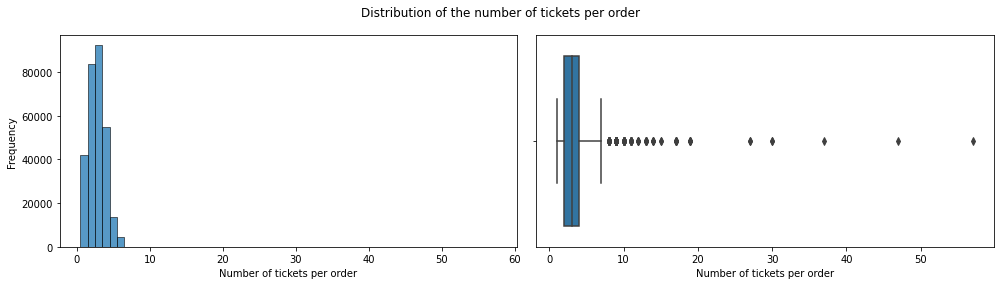

In [18]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['tickets_count'], discrete=True)
plt.xlabel('Number of tickets per order')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['tickets_count'])
plt.xlabel('Number of tickets per order')

plt.suptitle('Distribution of the number of tickets per order')
plt.tight_layout()
plt.show()

In [19]:
df[df['currency_code'] == 'rub'][['revenue','total']].describe()

,revenue,total
count,285512.000000,285512.000000
mean,548.036278,6330.838502
std,871.782124,8619.635281
min,-90.760000,-358.850000
25%,114.190000,2120.070000
50%,346.700000,4674.025000
75%,793.320000,8783.220000
max,81174.540000,811745.400000


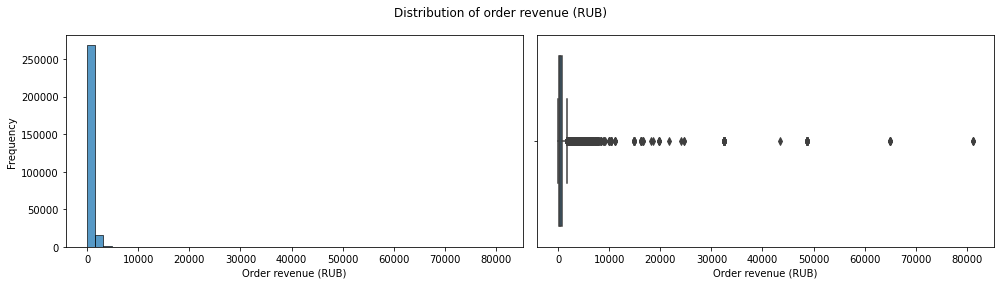

In [20]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df[df['currency_code'] == 'rub'], x='revenue', bins=50)
plt.xlabel('Order revenue (RUB)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(data=df[df['currency_code'] == 'rub'], x='revenue')
plt.xlabel('Order revenue (RUB)')

plt.suptitle('Distribution of order revenue (RUB)')
plt.tight_layout()
plt.show()

In [21]:
df[df['currency_code'] == 'kzt'][['revenue','total']].describe()

,revenue,total
count,5069.000000,5069.000000
mean,4995.206767,75236.969067
std,4916.752776,68039.218885
min,0.000000,0.000000
25%,518.100000,9353.700000
50%,3698.830000,61647.160000
75%,7397.660000,114868.830000
max,26425.860000,344606.500000


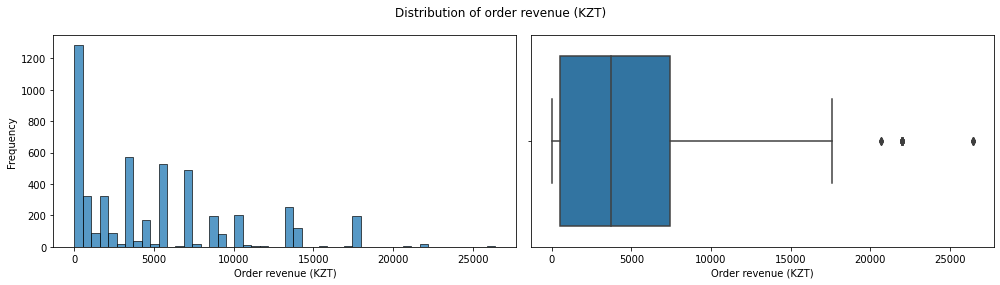

In [22]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df[df['currency_code'] == 'kzt'], x='revenue', bins=50)
plt.xlabel('Order revenue (KZT)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(data=df[df['currency_code'] == 'kzt'], x='revenue')
plt.xlabel('Order revenue (KZT)')

plt.suptitle('Distribution of order revenue (KZT)')
plt.tight_layout()
plt.show()

The `tickets_count` distribution shows the presence of right-tailed outliers. Nevertheless, the median (3 tickets per order) and the mean (2.7) are relatively close, suggesting that the distribution is relatively stable despite the outliers.

In the `revenue` and `total` columns, negative values are present for both currencies, likely reflecting refund transactions. Both distributions are right-skewed and contain a large number of outliers, as indicated by means that exceed medians and relatively large standard deviations.

Revenue in KZT (mean: 4,995; median: 3,698) is more evenly distributed than revenue in RUB (mean: 548; median: 346). This suggests that rare high-value orders have a stronger impact on the revenue distribution in RUB.

Outliers will be filtered separately for RUB and KZT using the IQR method:

In [23]:
Q1 = df.groupby('currency_code')['revenue'].transform('quantile', 0.25)
Q3 = df.groupby('currency_code')['revenue'].transform('quantile', 0.75)

IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['revenue'] >= lower) & (df['revenue'] <= upper)]

### 2.6 Feature engineering

For further analysis, we create several additional features.

We extract the month of order creation and create a column representing seasonality:

In [24]:
df['month'] = df['created_dt_msk'].dt.month
df['month'] = pd.to_numeric(df['month'], downcast='integer')

In [25]:
df['season'] = pd.cut(
    df['created_dt_msk'].dt.month,
    bins=[0, 2, 5, 8, 11, 12],
    labels=['зима', 'весна', 'лето', 'осень', 'зима'],
    ordered=False)

df['season'] = df['season'].astype(str)

Using the `final_tickets_tenge_df.csv` dataset, we convert order revenue to a single currency - Russian rubles:

In [26]:
df = df.merge(df_tenge, left_on =['created_dt_msk', 'currency_code'], right_on=['data', 'cdx'], how='left')

In [27]:
def convert_revenue (row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    else:
        return (row['revenue'] * row['curs']) / row['nominal']

df['revenue_rub'] = df.apply(convert_revenue, axis=1)

In [28]:
df = df.drop(columns=['data','nominal','curs','cdx'])

We calculate revenue per ticket in a separate column:

In [29]:
df['one_ticket_revenue_rub'] = df['revenue_rub'] / df['tickets_count']

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280390 entries, 0 to 280389
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                280390 non-null  int64         
 1   user_id                 280390 non-null  object        
 2   created_dt_msk          280390 non-null  datetime64[ns]
 3   created_ts_msk          280390 non-null  datetime64[ns]
 4   event_id                280390 non-null  int64         
 5   cinema_circuit          280390 non-null  object        
 6   age_limit               280390 non-null  int8          
 7   currency_code           280390 non-null  object        
 8   device_type_canonical   280390 non-null  object        
 9   revenue                 280390 non-null  float64       
 10  service_name            280390 non-null  object        
 11  tickets_count           280390 non-null  int8          
 12  total                   280390

In [31]:
deleted_rows = initial_row_count - df.shape[0]
deleted_rows_share = deleted_rows / initial_row_count
deleted_rows_share * 100

3.596024053718596

---
### 2.7 Interim summary

During the data preprocessing stage, the following steps were performed:

- **Merging datasets:** `final_tickets_orders_df.csv` and `final_tickets_events_df.csv` were merged into a single dataframe;
- **Data type conversion:** The `created_dt_msk` and `created_ts_msk` columns were converted to the `datetime64` type. The numeric columns `age_limit` and `tickets_count` were downcast to optimize memory usage;
- **Handling missing values:** Rows with missing values that appeared after merging were removed. Missing values in the `days_since_prev` column were retained, as they correctly indicate the absence of previous purchases;
- **Duplicate removal:** No exact duplicates were detected. 30 implicit duplicates based on key columns were identified and removed;
- **Outlier filtering:** Outliers were detected in the `revenue` column, which were filtered using the IQR method separately by currency;
- **Feature engineering:** 4 additional features were created:
  - `month` — order month;
  - `season` — order season (winter, spring, summer, autumn);
  - `revenue_rub` — order revenue converted to RUB;
  - `one_ticket_revenue_rub` — revenue per ticket.

Overall, about **3.6% of records** were excluded during preprocessing, which is not expected to have a significant impact on the analysis results.

---
<a id='exploratory-data-analysis'></a>
## 3. Exploratory data analysis

### 3.1. Seasonal patterns in order distribution across segments

#### 3.1.1  Monthly order volume dynamics

In [32]:
month_agg = df.groupby('month')['order_id'].nunique().reset_index()
month_agg.columns = ['month', 'order_count']
month_agg

,month,order_count
0,6,33335
1,7,39208
2,8,43292
3,9,67654
4,10,96901


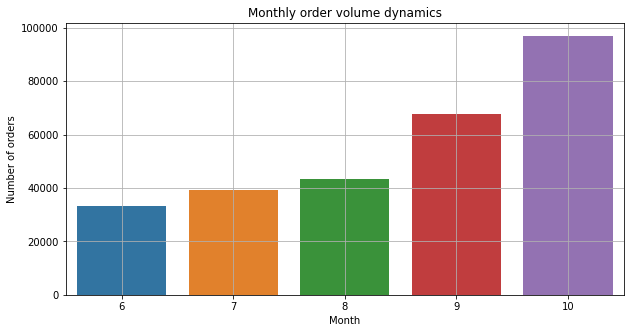

In [33]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=month_agg,
    x='month',
    y='order_count')

plt.title('Monthly order volume dynamics')
plt.xlabel('Month')
plt.ylabel('Number of orders')
plt.grid()
plt.show()

The total number of orders shows a consistent upward trend from June to October.

This growth can be explained by seasonality: after a relatively calm summer period of vacations and holidays, user activity recovers and increases in autumn.

#### 3.1.2  Order distribution across event types

In [34]:
agg_event_type = df[df['season'].isin(['лето', 'осень'])].groupby(['season','event_type_main'])['order_id'].nunique().reset_index(name='order_count').sort_values(by='order_count', ascending=False)
agg_event_type['orders_share'] = agg_event_type['order_count'] / agg_event_type.groupby('season')['order_count'].transform('sum')
agg_event_type

,season,event_type_main,order_count,orders_share
9,осень,концерты,60113,0.365306
2,лето,концерты,48688,0.420322
12,осень,театр,41754,0.253739
8,осень,другое,33047,0.200826
1,лето,другое,32157,0.277610
5,лето,театр,23242,0.200647
10,осень,спорт,18868,0.114661
11,осень,стендап,6742,0.040971
4,лето,стендап,6076,0.052454
3,лето,спорт,3004,0.025933


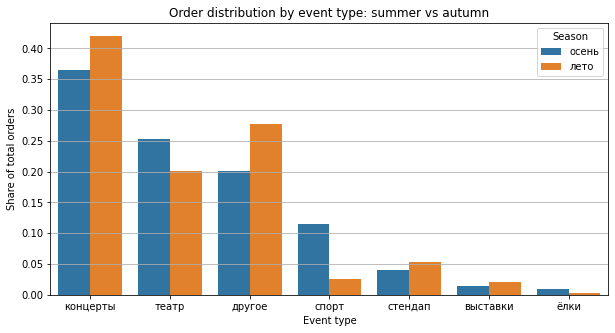

In [35]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=agg_event_type,
    x='event_type_main',
    y='orders_share',
    hue='season'
)

plt.title('Order distribution by event type: summer vs autumn')
plt.xlabel('Event type')
plt.ylabel('Share of total orders')
plt.grid(axis='y')
plt.legend(title='Season')
plt.show()

Across both seasons, three categories stand out as leaders by order share: concerts, theatre, and the “other” category.

Concerts rank first in both summer (~ 42% of total orders) and autumn (~ 36%). The second and third positions vary by season: in autumn, they are occupied by theatre (~ 25%) and “other” (~ 20%), while in summer the positions are reversed — “other” (~ 27%) and theatre (~ 20%).

Exhibitions and “New Year events” account for the smallest share of orders in both seasons.

The dominance of concerts suggests stable demand for this format regardless of season. The increase in the theatre share in autumn may be driven by weather changes, as users tend to prefer indoor events during colder months. The higher share of the “other” category in summer likely reflects a greater number of festivals and one-off outdoor events typical for the warm season.

#### 3.1.3  Order distribution across device types

In [36]:
agg_device_type = df[df['season'].isin(['лето', 'осень'])].groupby(['season','device_type_canonical'])['order_id'].nunique().reset_index(name='order_count').sort_values(by='order_count', ascending=False)
agg_device_type['orders_share'] = agg_device_type['order_count'] / agg_device_type.groupby('season')['order_count'].transform('sum')
agg_device_type

,season,device_type_canonical,order_count,orders_share
3,осень,mobile,131223,0.797442
1,лето,mobile,93478,0.806993
2,осень,desktop,33332,0.202558
0,лето,desktop,22357,0.193007


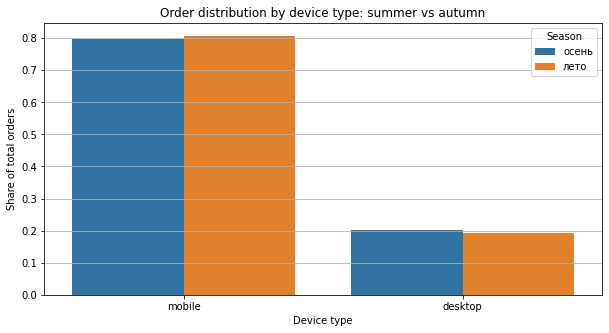

In [37]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=agg_device_type,
    x='device_type_canonical',
    y='orders_share',
    hue='season'
)

plt.title('Order distribution by device type: summer vs autumn')
plt.xlabel('Device type')
plt.ylabel('Share of total orders')
plt.grid(axis='y')
plt.legend(title='Season')
plt.show()

The distribution of orders by device type is almost identical in summer and autumn: approximately 80% of orders are made on mobile devices and about 20% on desktops. No meaningful seasonal shifts are detected.

This reflects stable user behavior and the consistent dominance of the mobile channel regardless of seasonality.

#### 3.1.4  Order distribution across event age ratings

In [38]:
agg_age_limit = df[df['season'].isin(['лето', 'осень'])].groupby(['season','age_limit'])['order_id'].nunique().reset_index(name='order_count').sort_values(by='order_count', ascending=False)
agg_age_limit['orders_share'] = agg_age_limit['order_count'] / agg_age_limit.groupby('season')['order_count'].transform('sum')
agg_age_limit

,season,age_limit,order_count,orders_share
8,осень,16,43095,0.261888
5,осень,0,39650,0.240953
7,осень,12,36021,0.218899
3,лето,16,33022,0.285078
6,осень,6,28753,0.174732
2,лето,12,23438,0.202340
0,лето,0,21192,0.182950
1,лето,6,20998,0.181275
4,лето,18,17185,0.148358
9,осень,18,17036,0.103528


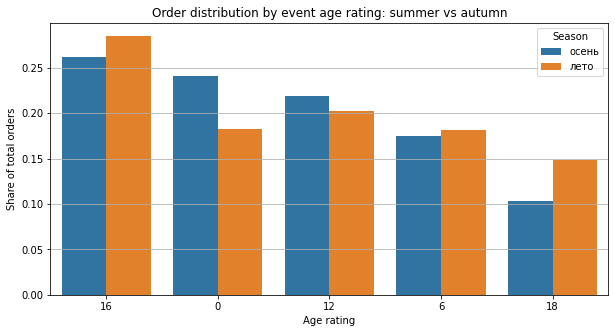

In [39]:
plt.figure(figsize=(10, 5))

order = (agg_age_limit.sort_values('orders_share', ascending=False)['age_limit'].unique())

sns.barplot(
    data=agg_age_limit,
    x='age_limit',
    y='orders_share',
    hue='season',
    order=order)

plt.title('Order distribution by event age rating: summer vs autumn')
plt.xlabel('Age rating')
plt.ylabel('Share of total orders')
plt.grid(axis='y')
plt.legend(title='Season')
plt.show()

The largest share of orders in both seasons comes from events rated 16+ (around 26% in autumn and 28% in summer).

In autumn, the share of events without age restrictions (0+) and with a 12+ rating is higher, while in summer the share of 16+ and 18+ events increases.

The 18+ category accounts for the smallest share of orders in both seasons.

The increase in the share of 0+ and 12+ events in autumn may be related to a return to more regular family-oriented leisure activities after the summer holidays. The higher share of 16+ and 18+ events in summer likely reflects stronger interest in adult-oriented evening events typical of the vacation period.

#### 3.1.5 Dynamics of average revenue per ticket by event type

In [40]:
agg_ticket_revenue = pd.pivot_table(
    df[df['season'].isin(['лето', 'осень'])],
    index='event_type_main',
    columns='season',
    values='one_ticket_revenue_rub',
    aggfunc='mean').reset_index()

agg_ticket_revenue['relative_difference'] = 100 * (agg_ticket_revenue['осень'] - agg_ticket_revenue['лето']) / agg_ticket_revenue['лето']
agg_ticket_revenue

season,event_type_main,лето,осень,relative_difference
0,выставки,86.185334,89.890589,4.299172
1,другое,74.356488,74.050094,-0.412061
2,концерты,294.037169,255.665268,-13.050017
3,спорт,50.376704,49.673220,-1.396446
4,стендап,202.625098,224.012071,10.554948
5,театр,204.923028,167.307318,-18.356019
6,ёлки,259.825526,213.691917,-17.755611


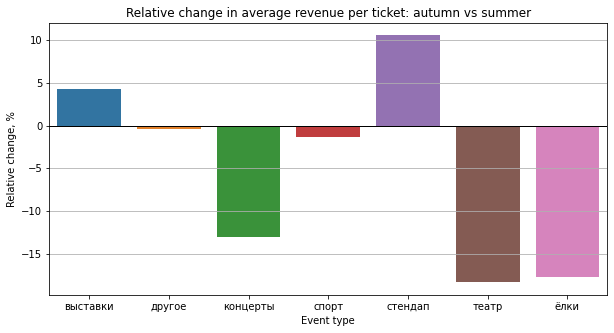

In [41]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=agg_ticket_revenue,
    x='event_type_main',
    y='relative_difference'
)

plt.axhline(0, color='black', linewidth=1)
plt.title('Relative change in average revenue per ticket: autumn vs summer')
plt.xlabel('Event type')
plt.ylabel('Relative change, %')
plt.grid(axis='y')
plt.show()

In autumn, the average revenue per ticket increases only in the exhibitions (+4.3%) and stand-up comedy (+10.5%) categories.

All other categories show a decrease in average ticket revenue compared to summer, most notably theatre (-18.3%), “New Year events” (-17.7%), and concerts (-13%).

In the “other” and sports categories, changes are minimal (below 2%), indicating relatively stable pricing.

The increase in average ticket price for exhibitions and stand-up events may be driven by a more higher-income audience. The decline in average ticket price in mass-market categories (concerts, theatre) likely reflects the active use of discounts and promotional offers to stimulate order volume.

#### 3.1.6  Interim summary

As autumn begins, the platform sees a **growth in the total number of orders**, which can be attributed to seasonal effects and a recovery in user activity following the summer vacation period.

The distribution of orders across key segments remains largely stable:
- By event type, **concerts** dominate in both summer (~ 42% of orders) and autumn (~ 36%), followed by **theatre** and the “other” category. This suggests structurally strong demand for concerts regardless of season. The share of theatre increases in autumn (~ 25% vs. ~ 20% in summer), which may reflect a shift toward indoor entertainment as weather conditions change.
- By device type, the distribution of orders does not change seasonally, indicating stable user behavior: **80% of orders are placed via mobile devices**, while about 20% come from desktops.
- By age rating, **events rated 16+** account for the largest share of orders in both seasons (~26% in autumn and ~28% in summer). In autumn, demand shifts slightly toward **0+ and 12+** events, likely driven by increased family-oriented activity after the end of summer holidays.

From a pricing perspective, the average revenue per ticket increases only for **exhibitions** (+4.3%) and **stand-up comedy** (+10.5%), while declining across other categories (theatre (-18.3%), holiday events (-17.7%), concerts (-13%)). This suggests that niche formats attract a more price-tolerant audience, whereas mass categories rely more heavily on discounts and promotions in autumn to drive higher order volumes.

### 3.2. User activity patterns during the autumn period

#### 3.2.1 Daily dynamics of user activity

In [42]:
autumn_agg = df[df['season'] == 'осень'].groupby('created_dt_msk').agg({'order_id':'nunique', 'user_id':'nunique', 'one_ticket_revenue_rub':'mean'}).reset_index().sort_values(by='created_dt_msk')
autumn_agg.columns = ['created_dt_msk', 'order_count', 'user_count', 'avg_ticket_revenue_rub']
autumn_agg['avg_order_count_per_user'] = autumn_agg['order_count'] / autumn_agg['user_count']
autumn_agg

,created_dt_msk,order_count,user_count,avg_ticket_revenue_rub,avg_order_count_per_user
0,2024-09-01,1280,550,186.886859,2.327273
1,2024-09-02,1348,565,181.422897,2.385841
2,2024-09-03,5078,770,77.332222,6.594805
3,2024-09-04,1726,672,169.235956,2.568452
4,2024-09-05,1879,723,177.001384,2.598893
...,...,...,...,...,...
56,2024-10-27,2778,1018,178.795668,2.728880
57,2024-10-28,2782,981,163.575472,2.835882
58,2024-10-29,2757,981,163.413425,2.810398
59,2024-10-30,2854,1029,173.215415,2.773567


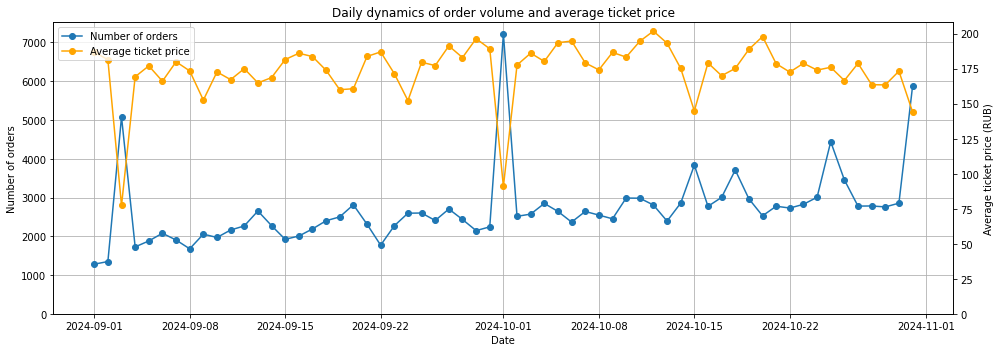

In [43]:
plt.figure(figsize=(14, 5))

line1, = plt.plot(
    autumn_agg['created_dt_msk'],
    autumn_agg['order_count'],
    marker='o',
    label='Number of orders')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.ylim(bottom=0)
plt.grid()

plt.twinx()

line2, = plt.plot(
    autumn_agg['created_dt_msk'],
    autumn_agg['avg_ticket_revenue_rub'],
    marker='o',
    color='orange',
    label='Average ticket price')

plt.ylabel('Average ticket price (RUB)')
plt.ylim(bottom=0)

plt.title('Daily dynamics of order volume and average ticket price')
plt.legend(handles=[line1, line2], loc='upper left')
plt.tight_layout()
plt.show()

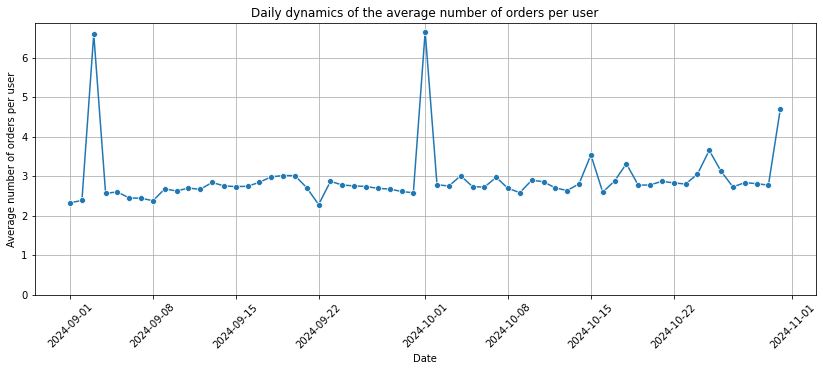

In [44]:
plt.figure(figsize=(14,5))

sns.lineplot(
    data=autumn_agg,
    x='created_dt_msk',
    y='avg_order_count_per_user',
    marker='o')

plt.title('Daily dynamics of the average number of orders per user')
plt.xlabel('Date')
plt.ylabel('Average number of orders per user')
plt.grid()
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.show()

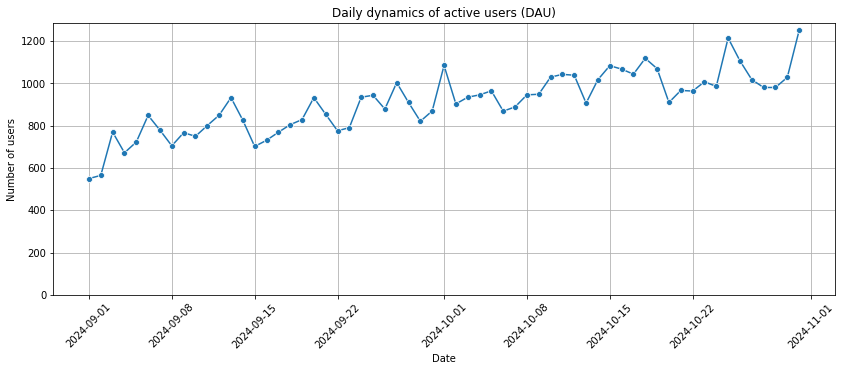

In [45]:
plt.figure(figsize=(14,5))

sns.lineplot(
    data=autumn_agg,
    x='created_dt_msk',
    y='user_count',
    marker='o')

plt.title('Daily dynamics of active users (DAU)')
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.grid()
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.show()

In September and October, there is a steady increase in overall order volume and user activity. Notable spikes in the number of orders are observed on September 3, October 1, and October 31.

The average number of orders per user remains generally stable (around 2-3), but increases significantly during these peaks. At the same time, the average ticket price shows no clear trend and stays around 170-200 RUB, yet drops significantly on peak-order days.

This combination of higher order volume and lower average ticket price likely reflects the effect of promotional campaigns or discounts at the beginning and end of the month designed to stimulate demand.

#### 3.2.2 Dynamics of user activity on weekdays vs. weekends

The anomalous peaks in the number of orders observed on September 3 and October 31 both occur on Tuesdays.

To avoid biasing the analysis of weekly seasonality, we exclude these dates from further analysis:

In [46]:
df['day_of_week'] = df['created_dt_msk'].dt.dayofweek + 1

In [47]:
anomaly_dates = pd.to_datetime(['2024-09-03', '2024-10-31'])

df_no_anomaly = df[~df['created_dt_msk'].isin(anomaly_dates)].copy()

In [48]:
autumn_agg_week = df_no_anomaly[df_no_anomaly['season'] == 'осень'].groupby('day_of_week').agg({'order_id':'nunique', 'user_id':'nunique', 'one_ticket_revenue_rub':'mean'}).reset_index()
autumn_agg_week.columns = ['day_of_week', 'order_count', 'user_count', 'avg_ticket_revenue_rub']
autumn_agg_week['avg_order_count_per_user'] = autumn_agg_week['order_count'] / autumn_agg_week['user_count']
autumn_agg_week

,day_of_week,order_count,user_count,avg_ticket_revenue_rub,avg_order_count_per_user
0,1,20975,4395,174.915370,4.772469
1,2,25839,4438,143.723816,5.822217
2,3,22305,4736,176.548530,4.709671
3,4,20620,4332,175.319914,4.759926
4,5,24222,4800,176.505674,5.046250
5,6,20789,4501,183.194762,4.618751
6,7,18858,4323,188.313404,4.362248


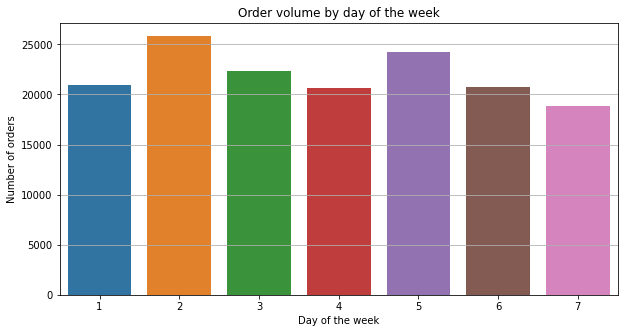

In [49]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=autumn_agg_week,
    x='day_of_week',
    y='order_count')

plt.title('Order volume by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Number of orders')
plt.grid(axis='y')
plt.show()

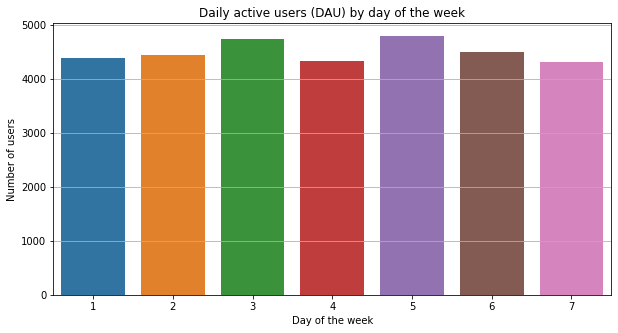

In [50]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=autumn_agg_week,
    x='day_of_week',
    y='user_count')

plt.title('Daily active users (DAU) by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Number of users')
plt.grid(axis='y')
plt.show()

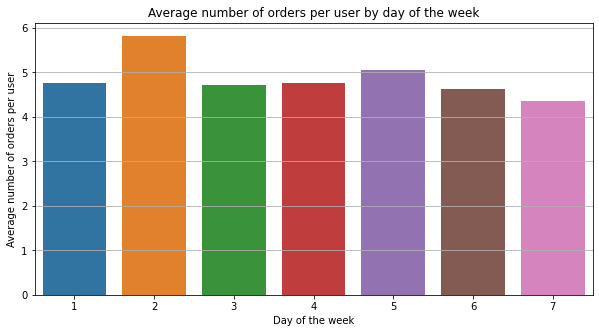

In [51]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=autumn_agg_week,
    x='day_of_week',
    y='avg_order_count_per_user')

plt.title('Average number of orders per user by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average number of orders per user')
plt.grid(axis='y')
plt.show()

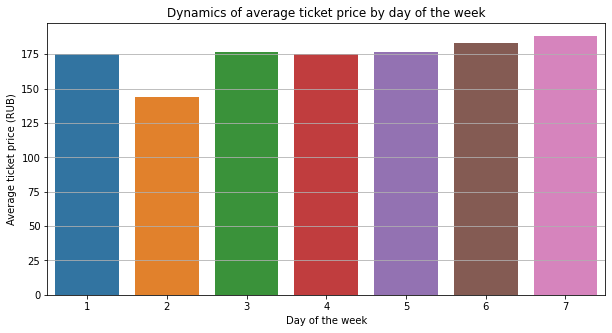

In [52]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=autumn_agg_week,
    x='day_of_week',
    y='avg_ticket_revenue_rub')

plt.title('Dynamics of average ticket price by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average ticket price (RUB)')
plt.grid(axis='y')
plt.show()

Both order volume and the average number of orders per user peak on Tuesday, followed by a slightly lower peak on Friday.

User activity remains relatively stable throughout the week, with slightly higher engagement on Wednesday and Friday. This pattern likely reflects advance planning of weekend leisure activities.

The average ticket price is lowest on Tuesday. The combination of higher order volume and lower prices suggests that discounts or promotional campaigns are likely launched on this day to stimulate demand.

During the weekend, both the total number of orders and the average number of orders per user decline.

#### 3.2.3 Interim summary

In autumn, the service demonstrates a **consistent growth in total orders and active users**, while the average number of orders per user and the average ticket price remain relatively stable.

Sharp spikes in order volume and average orders per user are observed at **the beginning and end of the month**, combined with a significant drop in the average ticket price. This indicates the impact of promotional mechanics, such as discounts or sales campaigns, used to drive short-term demand.

In terms of weekly patterns, both order volume and average orders per user peak on **Tuesday**, while overall user activity is fairly evenly distributed across the week, with a moderate increase on Wednesday and Friday. Higher weekday activity may be driven by users planning leisure activities for the upcoming weekend. The average ticket price is also lowest on Tuesday, reinforcing the hypothesis that promotions are concentrated on this day. On weekends, both total order volume and average orders per user decline.

Overall, the growth in total orders during autumn is driven by an increase in the number of active users** as well as short-term spikes in per-user ordering activity, which occur during discount and promotional periods.

### 3.3. Popular regions and ticketing partners

In [53]:
agg_region = df.groupby('region_name').agg({'event_id':'nunique', 'order_id':'nunique'}).reset_index()
agg_region['event_share'] = agg_region['event_id'] / agg_region['event_id'].sum()
agg_region['order_share'] = agg_region['order_id'] / agg_region['order_id'].sum()
agg_region.columns = ['region','event_count','order_count','event_share','order_share']
agg_region = agg_region.sort_values(by=['event_share','order_share'], ascending=False).head(10)
agg_region

,region,event_count,order_count,event_share,order_share
23,Каменевский регион,5845,86641,0.263051,0.309002
60,Североярская область,3777,42943,0.169982,0.153155
77,Широковская область,1229,15402,0.055311,0.054931
57,Светополянский округ,1075,7385,0.048380,0.026338
52,Речиновская область,700,6150,0.031503,0.021934
74,Травяная область,682,5001,0.030693,0.017836
11,Горицветская область,549,5128,0.024707,0.018289
61,Серебринская область,541,5398,0.024347,0.019252
78,Яблоневская область,532,5710,0.023942,0.020364
69,Тепляковская область,526,4364,0.023672,0.015564


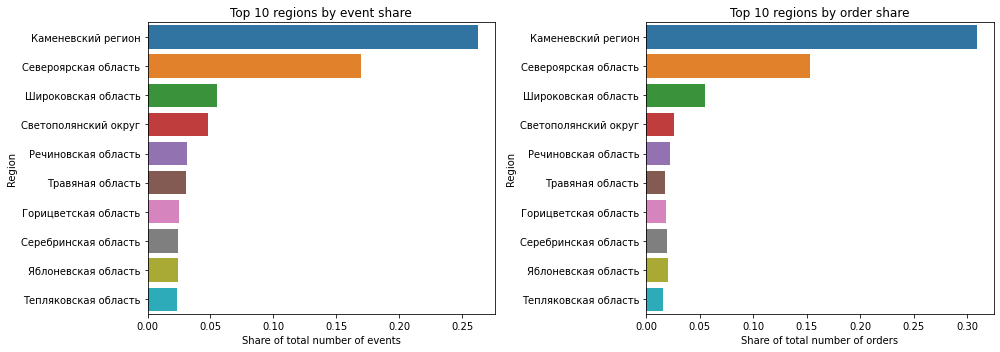

In [54]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.barplot(
    data=agg_region,
    x='event_share',
    y='region')

plt.title('Top 10 regions by event share')
plt.xlabel('Share of total number of events')
plt.ylabel('Region')

plt.subplot(1, 2, 2)
sns.barplot(
    data=agg_region,
    x='order_share',
    y='region')

plt.title('Top 10 regions by order share')
plt.xlabel('Share of total number of orders')
plt.ylabel('Region')

plt.tight_layout()
plt.show()

Two leaders stand out by both event share and order share: **Kamenevsky Region** (~ 26% of events and 31% of orders) and **Severyarskaya Oblast** (~ 17% of events and 15% of orders). Together, they represent nearly half of overall activity (44% of events and 46% of orders).

**Shirokovskaya Oblast** ranks third, with about 6% of both events and orders.

All other regions follow with a significant gap, each contributing less than 5% of total events and orders.

Notably, Kamenevsky Region is the only region in the top 10 where the share of orders exceeds the share of events. This suggests higher demand per event. In the remaining regions, the share of events exceeds the share of orders, indicating a high supply but lower attendance and conversion into orders.

In [55]:
agg_partner = df.groupby('service_name').agg({'event_id':'nunique', 'order_id':'nunique','revenue_rub':'sum'}).reset_index()
agg_partner.columns = ['partner','event_count','order_count','total_revenue_rub']
agg_partner['event_share'] = agg_partner['event_count'] / agg_partner['event_count'].sum()
agg_partner['order_share'] = agg_partner['order_count'] / agg_partner['order_count'].sum()
agg_partner['revenue_share'] = agg_partner['total_revenue_rub'] / agg_partner['total_revenue_rub'].sum()
agg_partner = agg_partner.sort_values(by='revenue_share', ascending=False).head(10)
agg_partner

,partner,event_count,order_count,total_revenue_rub,event_share,order_share,revenue_share
3,Билеты без проблем,4238,61480,2.147043e+07,0.174950,0.219266,0.160326
24,Мой билет,1292,33632,2.035468e+07,0.053336,0.119947,0.151994
25,Облачко,2299,25675,1.707216e+07,0.094906,0.091569,0.127483
21,Лови билет!,4849,40079,1.518337e+07,0.200173,0.142940,0.113379
8,Весь в билетах,837,14987,1.353880e+07,0.034553,0.053451,0.101098
5,Билеты в руки,3515,39951,1.250384e+07,0.145104,0.142484,0.093370
19,Край билетов,245,5601,5.353658e+06,0.010114,0.019976,0.039977
26,Прачечная,1018,10042,4.368469e+06,0.042024,0.035814,0.032621
13,Дом культуры,268,4147,3.794791e+06,0.011063,0.014790,0.028337
35,Яблоко,705,4821,3.483986e+06,0.029103,0.017194,0.026016


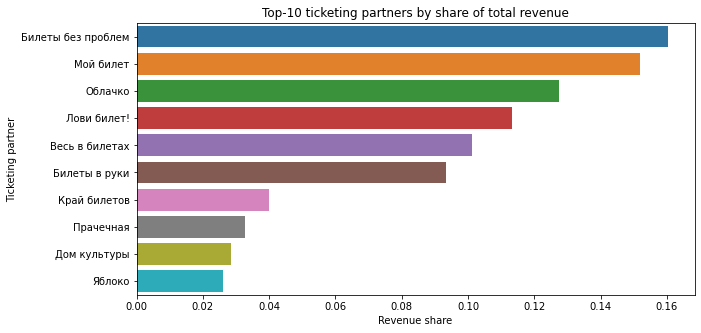

In [56]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=agg_partner,
    x='revenue_share',
    y='partner')

plt.title('Top-10 ticketing partners by share of total revenue')
plt.xlabel('Revenue share')
plt.ylabel('Ticketing partner')
plt.show()

Ticketing partners show a more balanced distribution compared to regions. **Six partners** stand out by revenue share (“Bilety Bez Problem”, “Moy Bilet”, “Oblachko”, “Lovi Bilet!”, “Ves v Biletakh”, “Bilety v Ruki”), each accounting for 9-16% of total revenue. Together, they generate **~ 74% of total revenue**.

The remaining partners each contribute less than 4% of revenue, indicating a long tail of smaller players.

Notably, “Moy Bilet” and “Ves v Biletakh” stand out as high-margin partners: their share of total revenue exceeds their shares of events and orders, which likely reflects a focus on premium or higher-priced events.

In contrast, “Lovi Bilet!” has the highest share of events among the top-10 partners but a comparatively lower share of orders and revenue. This may indicate a strategy focused on volume and variety rather than revenue per event.

#### 3.3.1 Interim summary

Two regions dominate in terms of both event share and order share: **Kamenevsky Region** (the leader, with **26% of events and 31% of orders**) and **Severyarskaya Oblast**. Together, they generate nearly **half of all events and orders**, indicating a high level of geographic concentration. Notably, Kamenevsky Region is the only region in the top-10 where the share of orders exceeds the share of events, which may point to higher demand per event. All other regions contribute less than 6% of total events and orders each.

Ticketing partners are distributed more evenly, though a group of leaders is still present. **Six partners** (“Bilety Bez Problem”, “Moy Bilet”, “Oblachko”, “Lovi Bilet!”, “Ves v Biletakh”, “Bilety v Ruki”) together generate around **74% of total revenue**.

Partners such as “Moy Bilet” and “Ves v Biletakh” appear to operate in higher-price segments, as their revenue share is disproportionately high relative to their event share. Conversely, “Lovi Bilet!” seems to prioritize scale and variety, with the highest event share but comparatively lower revenue share.

<a id='hypothesis-testing'></a>
## 4. Hypothesis testing

Next, we test a set of hypotheses aimed at identifying differences in user behavior between mobile and desktop users.

### 4.1 Average number of orders per user on mobile vs. desktop

To test the first hypothesis, we formulate the null and alternative hypotheses as follows:
- **H0**: The average number of orders per user for mobile users is **not higher** than that for desktop users.
- **H1**: The average number of orders per user for mobile users is **higher** than that for desktop users.

We calculate the number of orders per user and examine the sample sizes:

In [57]:
agg_device = df[(df['season'] == 'осень')].groupby(['device_type_canonical','user_id'])['order_id'].count().reset_index()
agg_device.columns = ['device','user_id','order_count']
agg_device.sort_values(by='order_count', ascending=False)

,device,user_id,order_count
5429,mobile,0beb8fc0c0a9ce1,4230
6107,mobile,18e9aead0a393e7,2046
11876,mobile,8187dac4be757a0,1744
8252,mobile,3ee7dc2e115847f,1740
9125,mobile,4ec8f6429431987,1679
...,...,...,...
8541,mobile,43e89dd257cdd4b,1
8542,mobile,43ed043df4922e2,1
8545,mobile,43f7bb1e5650eff,1
8549,mobile,441598f309fdd22,1


In [58]:
agg_device.groupby('device')['user_id'].nunique().reset_index()

,device,user_id
0,desktop,4795
1,mobile,14021


In total, there are 14,021 unique mobile users and 4,795 unique desktop users.

Next, we check whether the samples are independent:

In [59]:
agg_users = agg_device.groupby('user_id')['device'].nunique().reset_index().sort_values(by='device', ascending=False)
agg_users.groupby('device')['user_id'].nunique().reset_index()

,device,user_id
0,1,12448
1,2,3184


Overall, 3,184 users made purchases using both mobile devices and desktop computers.

To satisfy the independence assumption required for the statistical test, these users are excluded from further analysis:

In [60]:
agg_device = agg_device[~agg_device['user_id'].isin(agg_users.loc[agg_users['device'] == 2, 'user_id'])]

In [61]:
agg_device.groupby('device')['user_id'].nunique().reset_index()

,device,user_id
0,desktop,1611
1,mobile,10837


After removing overlapping users, the sample size remains adequate for conducting the statistical test.

Next, we examine the descriptive statistics of order counts:

In [62]:
agg_device['order_count'].describe()

count    12448.000000
mean         2.731844
std          3.990054
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        123.000000
Name: order_count, dtype: float64

Outliers are present in the data. We filter values above the 99th percentile for visualization purposes and examine the distribution by device type:

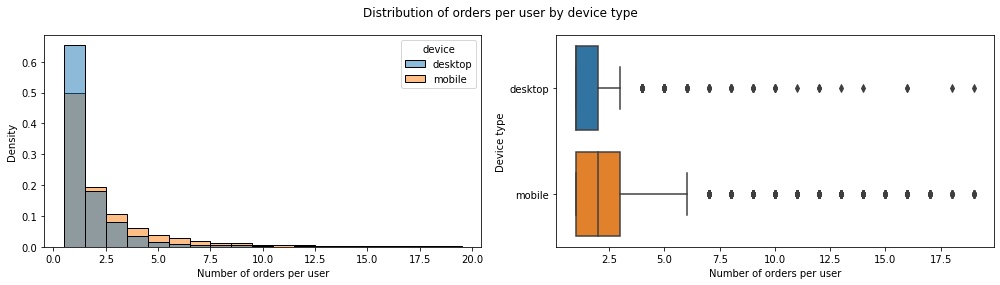

In [63]:
upper = agg_device['order_count'].quantile(0.99)

plt.figure(figsize = (14, 4))

plt.subplot(1, 2, 1)
sns.histplot(data= agg_device[agg_device['order_count'] <= upper], x= 'order_count', hue = 'device', discrete=True, stat='density', common_norm=False)
plt.xlabel('Number of orders per user')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.boxplot(data = agg_device[agg_device['order_count'] <= upper], x= 'order_count', y = 'device')
plt.xlabel('Number of orders per user')
plt.ylabel('Device type')

plt.suptitle('Distribution of orders per user by device type')
plt.tight_layout()
plt.show()

Even after filtering values using the 99th percentile, the distribution remains strongly right-skewed and deviates from normality. At the same time, the shape of the distribution is similar for both device types.

The plot shows that typical values for mobile users are higher than those for desktop users.

Next, we calculate the average number of orders per user by device type:

In [64]:
agg_mean = agg_device.groupby('device')['order_count'].mean().reset_index()
agg_mean

,device,order_count
0,desktop,1.956549
1,mobile,2.847098


In [65]:
percent_difference = 100 * (agg_mean[agg_mean['device'] == 'mobile']['order_count'].iloc[0] - agg_mean[agg_mean['device'] == 'desktop']['order_count'].iloc[0]) / agg_mean[agg_mean['device'] == 'mobile']['order_count'].iloc[0]
absolute_difference = agg_mean[agg_mean['device'] == 'mobile']['order_count'].iloc[0] - agg_mean[agg_mean['device'] == 'desktop']['order_count'].iloc[0]
print(f'Relative difference in the average number of orders per user: {percent_difference} %')
print(f'Absolute difference in the average number of orders per user: {absolute_difference} percentage points')

Relative difference in the average number of orders per user: 31.27919051046645 %
Absolute difference in the average number of orders per user: 0.8905491778259036 percentage points


The average number of orders per user among mobile users is **31% higher** (or 0.9 percentage points in absolute terms) than among desktop users.

To assess whether this difference is statistically significant, we apply the Mann–Whitney U test, as the distribution is heavily skewed and contains numerous outliers:

In [66]:
sample_1 = agg_device[agg_device['device'] == 'mobile']['order_count']
sample_2 = agg_device[agg_device['device'] == 'desktop']['order_count']

alpha = 0.05

results = st.mannwhitneyu(sample_1, sample_2, alternative='greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value: 1.6003896487434876e-40
Reject the null hypothesis


As the p-value is lower than the predefined significance level, we reject the null hypothesis.

We conclude that the average number of orders per user for mobile users is **statistically significantly higher** than for desktop users.

### 4.2 Average time between orders on mobile vs. desktop

To test the second hypothesis, we formulate the null and alternative hypotheses:

- **H0**: The average time between orders for mobile users is **not higher** than that for desktop users.
- **H1**: The average time between orders for mobile users is **higher** than that for desktop users.

Next, we calculate the average time between orders for each user:

In [67]:
agg_time_between_orders = df[(df['season'] == 'осень')].groupby(['device_type_canonical','user_id'])['days_since_prev'].mean().reset_index()
agg_time_between_orders.columns = ['device','user_id','time_between_orders']
agg_time_between_orders

,device,user_id,time_between_orders
0,desktop,0028d17a676f8c8,NaN
1,desktop,002b75ca606ba46,4.666667
2,desktop,002ec276eee9b0b,10.000000
3,desktop,0040e12d70fae81,39.000000
4,desktop,005fefeabf1e678,0.000000
...,...,...,...
18811,mobile,ffe73c50cbd71fc,0.000000
18812,mobile,ffed3ff067d4f12,26.000000
18813,mobile,fff13b79bd47d7c,20.666667
18814,mobile,fffcd3dde79eb2c,4.000000


We retain only users who placed more than one order and assess the sample sizes:

In [68]:
agg_time_between_orders = agg_time_between_orders.dropna(subset=['time_between_orders'])

In [69]:
agg_time_between_orders.groupby('device')['user_id'].nunique().reset_index()

,device,user_id
0,desktop,3976
1,mobile,10091


In total, there are 10,091 unique mobile users and 3,976 unique desktop users.

Next, we check whether the samples are independent:

In [70]:
agg_users_2 = agg_time_between_orders.groupby('user_id')['device'].nunique().reset_index().sort_values(by='device', ascending=False)
agg_users_2.groupby('device')['user_id'].nunique().reset_index()

,device,user_id
0,1,8121
1,2,2973


A total of 2,973 users made purchases using both mobile devices and desktop computers.

As with the previous hypothesis, these users are excluded from the analysis to satisfy the independence assumption required for the statistical test:

In [71]:
agg_time_between_orders = agg_time_between_orders[~agg_time_between_orders['user_id'].isin(agg_users_2.loc[agg_users_2['device'] == 2, 'user_id'])]

In [72]:
agg_time_between_orders.groupby('device')['user_id'].nunique().reset_index()

,device,user_id
0,desktop,1003
1,mobile,7118


After filtering, the sample size remains adequate for conducting the statistical test.

Next, we examine the descriptive statistics of the average time between orders:

In [73]:
agg_time_between_orders['time_between_orders'].describe()

count    8121.000000
mean       25.428006
std        30.627743
min         0.000000
25%         2.000000
50%        14.000000
75%        37.000000
max       148.000000
Name: time_between_orders, dtype: float64

Outliers are observed for this metric as well.

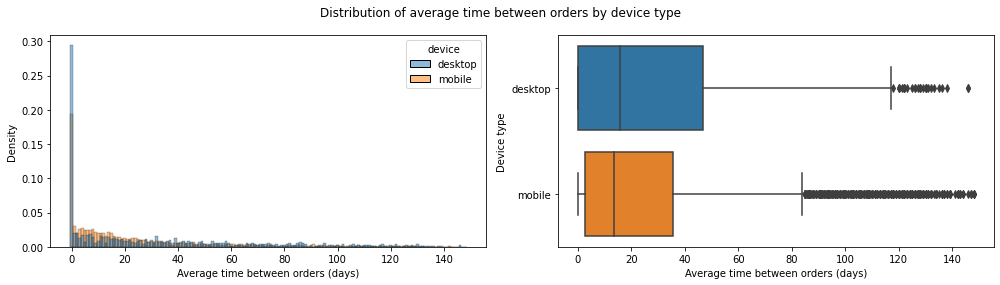

In [74]:
plt.figure(figsize = (14, 4))

plt.subplot(1, 2, 1)
sns.histplot(data= agg_time_between_orders, x= 'time_between_orders', hue = 'device', discrete=True, stat='density', common_norm=False)
plt.xlabel('Average time between orders (days)')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.boxplot(data = agg_time_between_orders, x= 'time_between_orders', y = 'device')
plt.xlabel('Average time between orders (days)')
plt.ylabel('Device type')

plt.suptitle('Distribution of average time between orders by device type')
plt.tight_layout()
plt.show()

The distribution is strongly right-skewed and deviates from normality. The shape of the distribution is similar for both device types.

The plot shows that typical values for desktop users are higher than those for mobile users.

Next, we calculate the average time between orders by device type:

In [75]:
agg_mean_2 = agg_time_between_orders.groupby('device')['time_between_orders'].mean().reset_index()
agg_mean_2

,device,time_between_orders
0,desktop,29.386423
1,mobile,24.870224


In [76]:
percent_difference = 100 * (agg_mean_2[agg_mean_2['device'] == 'mobile']['time_between_orders'].iloc[0] - agg_mean_2[agg_mean_2['device'] == 'desktop']['time_between_orders'].iloc[0]) / agg_mean_2[agg_mean_2['device'] == 'mobile']['time_between_orders'].iloc[0]
absolute_difference = agg_mean_2[agg_mean_2['device'] == 'mobile']['time_between_orders'].iloc[0] - agg_mean_2[agg_mean_2['device'] == 'desktop']['time_between_orders'].iloc[0]
print(f'Relative difference in the average time between orders: {percent_difference} %')
print(f'Absolute difference in the average time between orders: {absolute_difference} percentage points')

Relative difference in the average time between orders: -18.159059627740874 %
Absolute difference in the average time between orders: -4.51619889595635 percentage points


The average time between orders for mobile users is **18.2% lower** (or 4.5 percentage points in absolute terms) than for desktop users.

To assess whether this difference is statistically significant, we apply the Mann–Whitney U test. As with the previous hypothesis, a non-parametric test is used due to the presence of a large number of outliers in the data.

In [77]:
sample_1 = agg_time_between_orders[agg_time_between_orders['device'] == 'mobile']['time_between_orders']
sample_2 = agg_time_between_orders[agg_time_between_orders['device'] == 'desktop']['time_between_orders']

alpha = 0.05

results = st.mannwhitneyu(sample_1, sample_2, alternative='greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value: 0.6590982839206107
Fail to reject the null hypothesis


As the p-value is greater than the predefined significance level, there is no statistical evidence to reject the null hypothesis.

We conclude that the average time between orders for mobile users is **not statistically significantly higher** than for desktop users.

At the same time, descriptive statistics indicate that desktop users have a higher average time between orders. For this reason, we additionally test the opposite direction of the alternative hypothesis:

In [78]:
sample_1 = agg_time_between_orders[agg_time_between_orders['device'] == 'mobile']['time_between_orders']
sample_2 = agg_time_between_orders[agg_time_between_orders['device'] == 'desktop']['time_between_orders']

alpha = 0.05

results = st.mannwhitneyu(sample_1, sample_2, alternative='less')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value: 0.3409070130844294
Fail to reject the null hypothesis


In this case, the p-value is also above the chosen significance level; therefore, we fail to reject the null hypothesis. We confirm the conclusion that there are no statistically significant differences between the metrics.

### 4.3 Interim summary

The preliminary analysis showed that the distributions of the average number of orders per user and the average time between orders are highly skewed and contain outliers. Therefore, the Mann–Whitney U test was selected to test both hypotheses.

The statistical analysis led to the following conclusions:
- The **average number of orders per user** for mobile users is **statistically significantly higher** than for desktop users;
- The **average time between orders** for mobile users is **not statistically significantly higher** than for desktop users. Although descriptive statistics show that desktop users tend to place orders with longer intervals, this difference is not supported by statistical tests.

Overall, the results suggest that mobile users place more orders on average, while their purchase frequency is comparable to that of desktop users.

<a id='final-conclusions-and-recommendations'></a>
## 5. Final conclusions and recommendations

We analyzed data from **290,849 ticket orders** on Yandex Afisha and **22,427 associated events** covering the period from June to October 2024. The goal was to understand how user behavior and event demand change in autumn 2024 to support preparation for seasonal sales and promotional activity.

### 5.1 Key patterns in user behavior and event demand in autumn 2024

- **User activity increases in autumn**, with both order volume and the number of active users growing from June to October.
- **Category structure remains largely stable**:
    - **By event type:** Concerts remain the leading category in both summer and autumn (~ 42% of orders in summer and 36% in autumn), followed by theater and the “other” category. The share of theater increases in autumn, possibly reflecting higher demand for indoor events;
    - **By device type:** Device usage shows no seasonal shift (~ 80% of orders come from mobile devices and 20% from desktop);
    - **By age rating:** Events rated 16+ account for the largest share of orders in both seasons (~26% in autumn and ~28% in summer). The share of 0+ and 12+ events increases in autumn, suggesting increased family-oriented demand.
- **Average ticket revenue declines across most categories**, except exhibitions and stand-up, where it grows. This suggests broader use of discounts in mass categories to stimulate order volume.
- **Activity spikes occur at the beginning and end of the month**, when both order volume and average orders per user increase sharply on specific dates, while the average ticket price declines. This pattern is likely driven by promotional campaigns or discounts.
- **Weekday activity peaks on Tuesday**, with the highest order volume and lowest average ticket price, suggesting discount-driven demand. User activity is evenly distributed across weekdays, with moderate increases on Wednesday and Friday, potentially reflecting advance planning for weekend leisure.
- **Activity is highly concentrated geographically and by partners:** two regions (Kamenevsky Region and Severoyarskaya Oblast) account for ~44% of events and 46% of orders, while six ticketing partners generate ~ 74% of total revenue.
- **Mobile users place a higher average number of orders**, while their average time between orders does not differ significantly from that of desktop users.

### 5.2 Recommendations

- **Prioritize the mobile channel.** Mobile devices generate ~80% of orders, and mobile users place more orders on average. Mobile-first UX improvements and promotions are likely to deliver the highest impact.
- **Use concerts and theater as primary growth drivers.** These categories dominate autumn demand, with theater gaining share. Increased visibility in discovery and recommendation flows can drive volume, but declining average prices require careful calibration to avoid long-term revenue dilution.
- **Apply category-specific promotion strategies.** For exhibitions and stand-up, where average ticket revenue increases in autumn, efforts should focus on preserving and scaling monetization. Categories with declining average ticket prices may benefit more from volume-driven promotional tactics.
- **Focus on core regions and partners.** A small number of regions and ticketing partners generate the majority of orders and revenue, making them the most effective targets for capacity planning, marketing coordination, and campaign execution ahead of seasonal campaigns.